In [1]:
# Basic Setup
# import module(s) into namespace
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math
import nltk
from nltk.stem import WordNetLemmatizer

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.xkcd()

pd.set_option('display.max_colwidth', 2000) #important for getting all the text
# we set the upper bound to 2000 because Eminem's "Rap God" has 1,560 words 
# and set a record for the most words in a top 100 song ever

%pwd

u'/Users/darshanabenhur/Downloads'

In [2]:
# read in book quotes from CSV
df = pd.read_csv('billboard_top_music_with_lyrics_fixed.csv', delimiter="|", encoding='latin-1')

In [3]:
# replace contractions
import re

replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'in\'', 'ing'),
    (r'o\'er', 'over'),
    (r'\'bout', 'about'),
    ('\"', ''),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would')
]

class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    def replace(self, text):
        s = text.lower()
        for (pattern, repl) in self.patterns:
            (s, count) = re.subn(pattern, repl, s)
        return s

# yes I lowercase everything. I went back n' forth on this for a while. I end up lowercasing words like Chicago but can still
# extract the uniqueness of that word

In [4]:
from nltk.corpus import stopwords

nltk_stopwords = stopwords.words("english")
my_stopwords = nltk_stopwords + ["said",
                                 # 'love',
                                 'dee',
                                 'ay',
                                 'wop',
                                 'oh',
                                 'uh',
                                 'eh',                                 
                                 'ooh',
                                 'da',
                                 'la',
                                 'ah',
                                 'em',
                                 'oh',
                                 'ooh',
                                 'get',
                                 'go',
                                 'take',
                                 'say',
                                 'could',
                                 'would',
                                 'take',
                                 'like',
                                 'know',
                                 'make',
                                 'should',
                                 'think',
                                 'wa',
                                 '10', 
                                 '1814', 
                                 '18th', 
                                 '2000', 
                                 '22nd', 
                                 '23', 
                                 '23rd', 
                                 'aaa', 
                                 'aaaaah', 
                                 'aaah', 
                                 'aaay', 
                                 'aah',
                                 "0", 
                                 '000', 
                                 '10', 
                                 '100', 
                                 '11', 
                                 '12', 
                                 '13', 
                                 '14', 
                                 '15', 
                                 '16', 
                                 '17', 
                                 '18', 
                                 '19', 
                                 '20', 
                                 '25', 
                                 '30', 
                                 '40', 
                                 '50', 
                                 '500', 
                                 '60',
                                 'http',
                                 'static',
                                 'urx',
                                 'image',
                                 'io',
                                 'gif',
                                 'loader']


my_dict = {'gonna':'going to',
           'gotta':'got to'}

print my_dict

{'gotta': 'got to', 'gonna': 'going to'}


In [5]:
# basic data clensing to remove non-text artifacts from the corpus
# gonna use this simple method from earlier in the class. I'm sure there's a better method but I want a list I can edit easily
replacer = RegexpReplacer()

df['lyrics'] = df['lyrics'].map(lambda x: replacer.replace(x))
df['lyrics'] = map(lambda x: x.replace('\n', ' '), df['lyrics']) #removing a "newline" artifact
df['lyrics'] = map(lambda x: x.replace('(', ' '), df['lyrics']) # removing open parens from text
df['lyrics'] = map(lambda x: x.replace(')', ' '), df['lyrics']) # removing close parens from text
df['lyrics'] = map(lambda x: x.replace('\'', ' '), df['lyrics']) # removing apostraphes from text
df['lyrics'] = map(lambda x: x.replace('\"', ''), df['lyrics']) # removing apostraphes from text

df['artist'] = df['artist'].map(lambda x: replacer.replace(x))
df['artist'] = map(lambda x: x.replace('\n', ' '), df['artist']) #removing a "newline" artifact
df['artist'] = map(lambda x: x.replace('(', ' '), df['artist']) # removing open parens from text
df['artist'] = map(lambda x: x.replace(')', ' '), df['artist']) # removing close parens from text
df['artist'] = map(lambda x: x.replace('\'', ' '), df['artist']) # removing apostraphes from text
df['artist'] = map(lambda x: x.replace('\"', ''), df['artist']) # removing apostraphes from text

df['song'] = df['song'].map(lambda x: replacer.replace(x))
df['song'] = map(lambda x: x.replace('\n', ' '), df['song']) #removing a "newline" artifact
df['song'] = map(lambda x: x.replace('(', ' '), df['song']) # removing open parens from text
df['song'] = map(lambda x: x.replace(')', ' '), df['song']) # removing close parens from text
df['song'] = map(lambda x: x.replace('\'', ' '), df['song']) # removing apostraphes from text
df['song'] = map(lambda x: x.replace('\"', ''), df['song']) # removing apostraphes from text

In [6]:
print df.columns
print df.dtypes
print df.shape
df.tail(5)

# we now have our corpus with songs, artists, and lyrics cleaned up, all lowercase

Index([u'year', u'rank', u'song', u'artist', u'lyrics'], dtype='object')
year       int64
rank       int64
song      object
artist    object
lyrics    object
dtype: object
(760, 5)


,year,rank,song,artist,lyrics
755,2015,10,the hills,the weeknd,"your man on the road, he doing promo you said keep our business on the low-low i am just tryna get you out the friend zone cause you look even better than the photos i cannot find your house, send me the info driving through the gated residential found out i was coming, sent your friends home keep on tryna hide it but your friends know i only call you when it is half past five the only time that i will be by your side i only love it when you touch me, not feel me when i am fucked up, that is the real me when i am fucked up, that is the real me, yeah i only fuck you when it is half past five the only time i would ever call you mine i only love it when you touch me, not feel me when i am fucked up, that is the real me when i am fucked up, that is the real me, babe i ama let you know and keep it simple tryna keep it up, do not seem so simple i just fucked two bitches fore i saw you you gon have to do it at my tempo always tryna send me off to rehab drugs start to feeling like it is decaf i am just tryna live life for the moment and all these motherfuckers want a real love i only call you when it is half past five the only time that i will be by your side i only love it when you touch me, not feel me when i am fucked up, that is the real me when i am fucked up, that is the real me, yeah i only fuck you when it is half past five the only time i would ever call you mine i only love it when you touch me, not feel me when i am fucked up, that is the real me when i am fucked up, that is the real me, babe hills have eyes, the hills have eyes who are you to judge, who are you to judge? hide your lies, girl, hide your lies only you to trust, only you i only call you when it is half past five the only time that i will be by your side i only love it when you touch me, not feel me when i am fucked up, that is the real me when i am fucked up, that is the real me, yeah i only fuck you when it is half past five the only time i would ever call you mine i only love it when ..."
756,2015,2,thinking out loud,ed sheeran,"when your legs do not work like they used to before and i cannot sweep you off of your feet will your mouth still remember the taste of my love will your eyes still smile from your cheeks and darling i will be loving you til we are 70 and baby my heart could still fall as hard at 23 and i am thinking about how people fall in love in mysterious ways maybe just the touch of a hand oh me i fall in love with you every single day and i just wanna tell you i am so honey now take me into your loving arms kiss me under the light of a thousand stars place your head on my beating heart i am thinking out loud maybe we found love right where we are when my hair is all but gone and my memory fades and the crowds do not remember my name when my hands do not play the strings the same way, mm i know you will still love me the same cause honey your soul can never grow old, it is evergreen baby your smile is forever in my mind and memory i am thinking about how people fall in love in mysterious ways maybe it is all part of a plan i will just keep on making the same mistakes hoping that you will understand but baby now take me into your loving arms kiss me under the light of a thousand stars place your head on my beating heart i am thinking out loud that maybe we found love right where we are, oh so baby now take me into your loving arms kiss me under the light of a thousand stars oh darling, place your head on my beating heart i am thinking out loud that maybe we found love right where we are oh maybe we found love right where we are and we found love right where we are"
757,2015,4,trap queen,fetty wap,"i am like hey, what is up, hello seen yo pretty ass soon as you came in that door i just wanna chill, got a sack for us to roll married to the money, introduced her to my stove showed her how to whip it, now she remixing for low she my trap queen, let her hit the bando we be counting up, 

In [7]:
from nltk.stem import WordNetLemmatizer

# Stemming has proven to be unreliable. How do we reconcile the following stemmed words?
# "beau" is this stemmed from beauty? beautiful? beaut? Or is it referring to someone's lover?

lemmList = []
lemmer = WordNetLemmatizer() 
#define method (http://www.nltk.org/api/nltk.stem.html#nltk.stem.porter.PorterStemmer)

for row in df['lyrics']:
    text = row.split() #splits the text into a list of pieces
    stemtext = [lemmer.lemmatize(word) for word in text] #stems each word individually
    stem2text = [' '.join(stemtext)] #picks out all the text and sticks it together with spaces
    lemmList += stem2text #creates a list of stemmed strings


df['cleanText'] = lemmList #creates a new column out of stemmed text 

df['cleanText'] = [" ".join([lemmer.lemmatize(word, pos = "v") for word in sentence.split()]) for sentence in df['cleanText']]
df['cleanText'] = [" ".join([lemmer.lemmatize(word, pos = "r") for word in sentence.split()]) for sentence in df['cleanText']]
df['cleanText'] = [" ".join([lemmer.lemmatize(word, pos = "a") for word in sentence.split()]) for sentence in df['cleanText']]

#### Create our feature space

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv_prelim = CountVectorizer(binary=True,
                            lowercase = False, 
                            stop_words = my_stopwords,
                            max_df=0.85,
                            min_df=0.0225, 
                            ngram_range = (1,2))

cv_text = cv_prelim.fit_transform(df['cleanText'])

tf_prelim = TfidfVectorizer(binary=False,
                            use_idf=True,
                            lowercase = False,
                            stop_words = my_stopwords,
                            max_df = 0.85, 
                            min_df = 0.0225,
                            ngram_range = (1,2))

tf_text = tf_prelim.fit_transform(df['cleanText'])

print type(cv_text)
print cv_text.shape

print type(tf_text)
print tf_text.shape

<class 'scipy.sparse.csr.csr_matrix'>
(760, 458)
<class 'scipy.sparse.csr.csr_matrix'>
(760, 458)


In [9]:
cv_df = pd.DataFrame(cv_text.toarray(), columns = cv_prelim.get_feature_names())
tf_df = pd.DataFrame(tf_text.toarray(), columns = tf_prelim.get_feature_names())

In [10]:
print cv_df.shape
print type(cv_df)
cv_df.head()

(760, 458)
<class 'pandas.core.frame.DataFrame'>


,across,act,air,alive,alone,along,alright,always,angel,another,...,wrong,ya,yeah,yeah yeah,year,yes,yesterday,yet,yo,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print tf_df.shape
print type(tf_df)
tf_df.head()

(760, 458)
<class 'pandas.core.frame.DataFrame'>


,across,act,air,alive,alone,along,alright,always,angel,another,...,wrong,ya,yeah,yeah yeah,year,yes,yesterday,yet,yo,young
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.308220,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.070304,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.094693,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.096171,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


##### Start using our Feature Space

In [12]:
# assign decades to each song to use later on for comparing word use in lyrics in songs between decades
df['decade'] = 10 * (df['year'] // 10)

In [13]:
# value counts looks like it worked. Each 10 years has top 10 songs for the decade and = 100 songs
df.decade.value_counts()

2000    100
1990    100
1980    100
1970    100
1960    100
1950    100
1940    100
2010     60
Name: decade, dtype: int64

In [14]:
decade1940 = df[df['decade'] == 1940]
decade1950 = df[df['decade'] == 1950]
decade1960 = df[df['decade'] == 1960]
decade1970 = df[df['decade'] == 1970]
decade1980 = df[df['decade'] == 1980]
decade1990 = df[df['decade'] == 1990]
decade2000 = df[df['decade'] == 2000]
decade2010 = df[df['decade'] == 2010]

In [15]:
tf_df['decade'] = df['decade']
tf_df.decade.value_counts()

2000    100
1990    100
1980    100
1970    100
1960    100
1950    100
1940    100
2010     60
Name: decade, dtype: int64

In [16]:
cv_df['decade'] = df['decade']
cv_df.decade.value_counts()

2000    100
1990    100
1980    100
1970    100
1960    100
1950    100
1940    100
2010     60
Name: decade, dtype: int64

In [17]:
cv_df.head()

,across,act,air,alive,alone,along,alright,always,angel,another,...,ya,yeah,yeah yeah,year,yes,yesterday,yet,yo,young,decade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1940
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1940
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1940
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1940
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1940


In [18]:
# Average words per song over the decades. Do we use more or less words per song? More or less unique words?

In [19]:
df['wordCount'] = pd.value_counts(df['lyrics'])

In [20]:
# evaluate distribution of phrases or words over time and look for patterns
# Look at: love, sex, baby, god, 

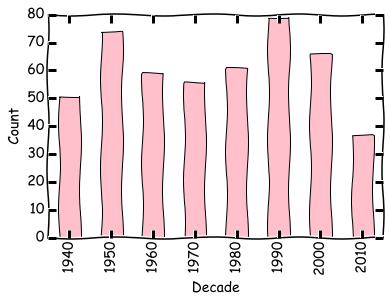

In [21]:
Love = df[df['cleanText'].str.contains("love")]

Love = pd.pivot_table(Love, index=['decade'], values=['cleanText'], aggfunc=[len])

plot = Love.plot(kind='bar', color='Pink')
plot.legend_.remove()
plot.set_xlabel("Decade")
plot.xaxis
plot.set_ylabel('Count')

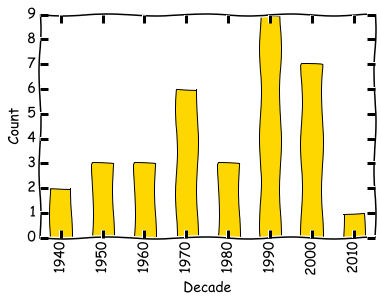

In [22]:
God = df[df['cleanText'].str.contains("god")]

God = pd.pivot_table(God, index=['decade'], values=['cleanText'], aggfunc=[len])

plot = God.plot(kind='bar', color='Gold')
plot.legend_.remove()
plot.set_xlabel("Decade")
plot.set_ylabel('Count')

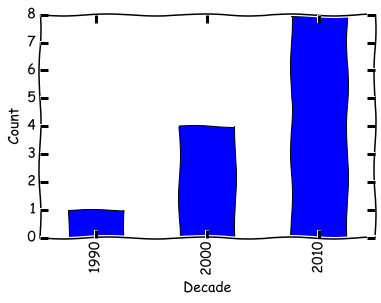

In [23]:
Bitch = df[df['cleanText'].str.contains("bitch")]

Bitch = pd.pivot_table(Bitch, index=['decade'], values=['cleanText'], aggfunc=[len])

plot = Bitch.plot(kind='bar', color='Blue')
plot.legend_.remove()
plot.set_xlabel("Decade")
plot.set_ylabel('Count')

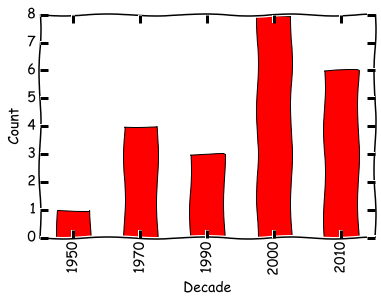

In [24]:
Sex = df[df['cleanText'].str.contains("sex")]

Sex = pd.pivot_table(Sex, index=['decade'], values=['cleanText'], aggfunc=[len])

plot = Sex.plot(kind='bar', color='Red')
plot.legend_.remove()
plot.set_xlabel("Decade")
plot.set_ylabel('Count')

# Sentiment Analysis

In [25]:
df.to_csv('billboard_lyrics_fixed.csv', encoding='utf_8', sep='|')

In [36]:
#pos_df = pd.read_csv('pos_sent.csv', encoding='ascii', sep='|')

In [29]:
neg_df = pd.read_csv('neg_sent.csv', encoding='ascii', sep='|')

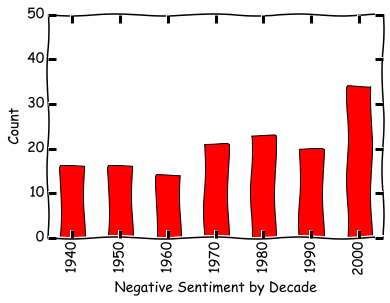

In [30]:
negSentPlot = pd.pivot_table(neg_df, index=['decade'], values=['count'])

plot = negSentPlot.plot(kind='bar', color='Red')
# plot.legend_.remove()
plot.set_xlabel("Negative Sentiment by Decade")
plot.axis(ymin=0, ymax=50)
plot.legend_.remove()
plot.set_ylabel('Count')

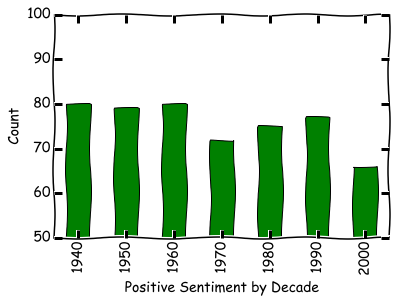

In [31]:
posSentPlot = pd.pivot_table(pos_df, index=['decade'], values=['count'])

plot = posSentPlot.plot(kind='bar', color='Green')
plot.set_xlabel("Positive Sentiment by Decade")
plot.axis(ymin=50, ymax=100)
plot.legend_.remove()
plot.set_ylabel('Count')

In [35]:
#some dictionaries assign a value - like the positivity measure in the news stories
afinn = dict(map(lambda (k,v): (k,int(v)), [ line.split('\t') for line in open("wk4-AFINN-111.txt") ]))
print type(afinn), len(afinn)
for key, value in sorted(afinn.items())[0:10]:
    print key + " => " + str(value)
print "~~~~~~~~~~~~"
for key, value in sorted(afinn.items())[2467:]:
    print key + " => " + str(value)

<type 'dict'> 2477
abandon => -2
abandoned => -2
abandons => -2
abducted => -2
abduction => -2
abductions => -2
abhor => -3
abhorred => -3
abhorrent => -3
abhors => -3
~~~~~~~~~~~~
yeah => 1
yearning => 1
yeees => 2
yes => 1
youthful => 2
yucky => -2
yummy => 3
zealot => -2
zealots => -2
zealous => 2


In [36]:
#some sort into buckets
HLpos = [line.strip() for line in  open('wk4-HLpos.txt','r')]
HLneg = [line.strip() for line in  open('wk4-HLneg.txt','r')]
print "HL pos  size: " + str(len(HLpos))
print HLpos[0:10]
print "HL neg  size: " + str(len(HLneg))
print HLneg[0:10]

HL pos  size: 2006
['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
HL neg  size: 4783
['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [37]:
def afinn_sent(inputstring):
    
    sentcount =0
    for word in inputstring.split():  
        if word in afinn:
            sentcount = sentcount + afinn[word]
            
    
    if (sentcount < 0):
        sentiment = 'Negative'
    elif (sentcount >0):
        sentiment = 'Positive'
    else:
        sentiment = 'Neutral'
    
    return sentiment
    #return sentcount

In [38]:
df['afinn-sent'] = map(lambda x: afinn_sent(x), df['cleanText'])

In [39]:
df.dtypes

year            int64
rank            int64
song           object
artist         object
lyrics         object
cleanText      object
decade          int64
wordCount     float64
afinn-sent     object
dtype: object

In [40]:
df['afinn-sent'].value_counts()

Positive    567
Negative    164
Neutral      29
Name: afinn-sent, dtype: int64

### Topic Extraction by Decade

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5
n_top_words = 5

lda = LatentDirichletAllocation(n_topics=n_topics,
                                   max_iter=10,
                                   learning_decay = .5,
                                   learning_method='online', 
                                   learning_offset=20.,
                                   random_state=0)



In [43]:
# nice function for printing topic information
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [44]:
decade1940 = df[df['decade'] == 1940]
decade1950 = df[df['decade'] == 1950]
decade1960 = df[df['decade'] == 1960]
decade1970 = df[df['decade'] == 1970]
decade1980 = df[df['decade'] == 1980]
decade1990 = df[df['decade'] == 1990]
decade2000 = df[df['decade'] == 2000]
decade2010 = df[df['decade'] == 2010]

In [45]:
#Code snippet for assigning topic labels - not well written (and not mine) but it works
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Requires some globally defined variables (which is why I don't like it)
# topics - the content of nmf.components_ 
# feature_names - the contents of get_feature names
# n_top_words - number of words per topic


# define a function for determining the most similar topic
def topic_sim(x):
    top_sim = 0
    top_topic = np.array([])
    # iterate over topics
    for idx, topic in enumerate(topics):
       
        # calculate cosine similarity - substitute euclidean distance if that is your preferred metric
        sim = cosine_similarity(x, topic)
        if sim > top_sim:
            top_sim = sim
            top_topic = topic
            
    # return the text feature names by indeing back into feature_names (assigned earlier)   

    return " ".join([feature_names[i] for i in top_topic.argsort()[:-n_top_words - 1:-1]])




### Tfidf - Topic Extraction the 40's

In [46]:
tf_text = tf_prelim.fit_transform(decade1940['cleanText'])
lda.fit(tf_text)

feature_names = tf_prelim.get_feature_names()

print("Topics for texts in 1940's TFIDF LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 1940's TFIDF LDA model:
Topic #0:
may every cannot must find
Topic #1:
love darling play eye near
Topic #2:
love love love wish heart back
Topic #3:
heart love always tell believe
Topic #4:
long dream christmas mule well
()


### CV - Topic Extraction the 40's

In [47]:
cv_text = cv_prelim.fit_transform(decade1940['cleanText'])
lda.fit(cv_text)

feature_names = cv_prelim.get_feature_names()

print("Topics for texts in 1940's CV LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 1940's CV LDA model:
Topic #0:
dream old sky heart find
Topic #1:
love night come one find
Topic #2:
heart love cannot one sweet
Topic #3:
heart tell love believe always
Topic #4:
one may cause day child
()


### Tfidf - Topic Extraction the 50's

In [48]:
tf_text = tf_prelim.fit_transform(decade1990['cleanText'])
lda.fit(tf_text)

feature_names = tf_prelim.get_feature_names()

print("Topics for texts in 1990's TFIDF LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 1990's TFIDF LDA model:
Topic #0:
jump jump jump huh hold love
Topic #1:
baby love want one let
Topic #2:
hey snow kiss lick compare
Topic #3:
love always always love love always swear
Topic #4:
look word baby sweet first
()


### CV - Topic Extraction the 50's

In [49]:
cv_text = cv_prelim.fit_transform(decade1990['cleanText'])
lda.fit(cv_text)

feature_names = cv_prelim.get_feature_names()

print("Topics for texts in 1990's CV LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 1990's CV LDA model:
Topic #0:
see year time one care
Topic #1:
love want feel time cause
Topic #2:
love life cannot day eye
Topic #3:
love see always break right
Topic #4:
feel baby never yeah night
()


### Tfidf - Topic Extraction the Aughts's

In [50]:
tf_text = tf_prelim.fit_transform(decade2000['cleanText'])
lda.fit(tf_text)

feature_names = tf_prelim.get_feature_names()

print("Topics for texts in 2000's TFIDF LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 2000's TFIDF LDA model:
Topic #0:
bounce beat must woo hope
Topic #1:
bad day cannot head reason
Topic #2:
forever ever shit club dance
Topic #3:
right love keep walk crazy
Topic #4:
love girl let baby look
()


### CV - Topic Extraction the Aught's

In [51]:
cv_text = cv_prelim.fit_transform(decade2000['cleanText'])
lda.fit(cv_text)

feature_names = cv_prelim.get_feature_names()

print("Topics for texts in 2000's CV LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 2000's CV LDA model:
Topic #0:
roll key gotta block let
Topic #1:
see give right come want
Topic #2:
nothing lil mama break lil mama
Topic #3:
way love time see one
Topic #4:
cause love let come feel
()


### Tfidf - Topic Extraction for Today's Hits

In [52]:
tf_text = tf_prelim.fit_transform(decade2010['cleanText'])
lda.fit(tf_text)

feature_names = tf_prelim.get_feature_names()

print("Topics for texts in 2010's TFIDF LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 2010's TFIDF LDA model:
Topic #0:
fuck jagger somebody shut move
Topic #1:
tonight whoa dirty doe california
Topic #2:
love na cannot need na na
Topic #3:
love bass baby watch want
Topic #4:
cause love gonna shake light
()


### CV - Topic Extraction for Today's Hits

In [53]:
cv_text = cv_prelim.fit_transform(decade2010['cleanText'])
lda.fit(cv_text)

feature_names = cv_prelim.get_feature_names()

print("Topics for texts in 2010's CV LDA model:")
print_top_words(lda, feature_names, n_top_words)

Topics for texts in 2010's CV LDA model:
Topic #0:
hold night back see bass
Topic #1:
okay already superman whip kill
Topic #2:
love cause come cannot way
Topic #3:
baby cause want bad come
Topic #4:
feel heart time let thing
()


In [54]:
decade2010.dtypes

year            int64
rank            int64
song           object
artist         object
lyrics         object
cleanText      object
decade          int64
wordCount     float64
afinn-sent     object
dtype: object

In [55]:
# let's add these topic labels to our dataframe
# define the global variables 
# topics - the content of components_ 
# feature_names - the contents of get_feature names
# temp - the array version of the vectorized feature space

#assign candidate topics based on lsa output
topics = lda.components_

#recast document term matrix as a numpy array (if it was a sparse matrix)
temp = tf_text.toarray()

# create a vector of topic labels that can be appended to the original dataframe
decade2010['lda_topics'] = np.apply_along_axis(topic_sim, axis=1, arr=temp)


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Wordclouds

In [27]:
nltk_stopwords = stopwords.words("english")
my_stopwords = nltk_stopwords + ["said",'10','1814', '18th', '2000', '22nd', '23', '23rd', 'aaa', 'aaaaah', 'darling',
                                 'wah','ooo','tu','eh','mine','nae','eh','shake','world','long','round','cry','bad',
                                 'song','lover','hand','help','mind','light','break','please','fall','crazy','lonely',
                                 'aaah','aaay','ha','doo','aah',"0", '000', '10', '100', '11', '12', '13', '14', '15', 
                                 '16', '17', '18', '19', '20', '25', '30', '40', '50', '500', '60','http','sing',
                                 'tonight','still','roll','star','without','blue','much','really','le','beat','together',
                                 'static','urx','image','give','rock','back','right','around','need','call','way',
                                 'every','good','move','thing','old','try','hey','keep','leave','watch','boy','miss',
                                 'io','feel','dream','boom','tell','day','see','never','want','girl','night','wo','yi','gif',
                                 'sh','loader','da','ba','la','play','sweet','ah','na','em','oh','ooh','get','go','take','say','yo',
                                 'heart','always','cause','life','dance','little','away','look','live','time','hoo','cannot','could','come','would','take',
                                 'like','know','gotta','make','should','think','wa','yeah','let','kiss','one', 'well',
                                 'may','ay','gonna','ya','true','music','hear','eye','find','uh','nah','hold','ever','lang','wanna','love','baby']


#Love,Baby,yeah,let,one taken out due to the frequency of words
#I kept only unique big words so words like kiss was taken out because it was one of  the most common words in multiple
#decades

//anaconda/lib/python2.7/site-packages/wordcloud/wordcloud.py:286: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0 and"


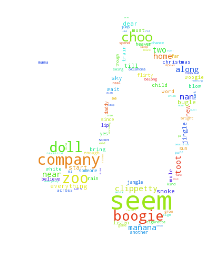

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade1940['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                     height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_1940.png', dpi=300)
plt.show()

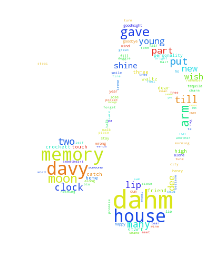

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade1950['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                      height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_1950.png', dpi=300)
plt.show()

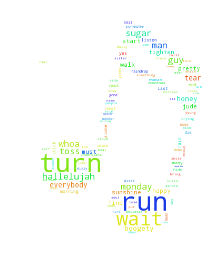

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade1960['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                      height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_1960.png', dpi=300)
plt.show()

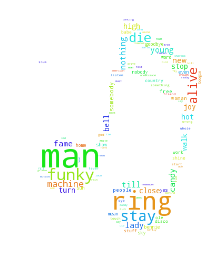

In [31]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade1970['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                      height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_1970.png', dpi=300)
plt.show()

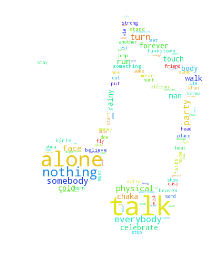

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade1980['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                      height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_1980.png', dpi=300)
plt.show()

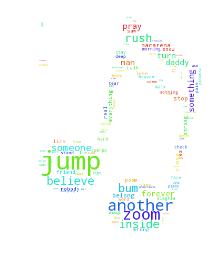

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade1990['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                      height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_1990.png', dpi=300)
plt.show()

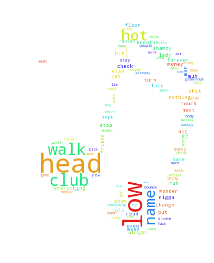

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade2000['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                      height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_2000.png', dpi=300)
plt.show()

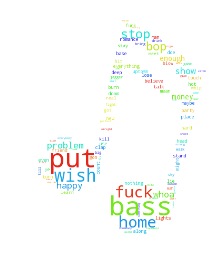

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

twitter_mask = imread('./music.png', flatten=True)

words = ' '.join(decade2010['cleanText'])

wordcloud = WordCloud(mask=twitter_mask, max_words=100, stopwords=my_stopwords, width=3600,
                      height=2800, background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_2010.png', dpi=300)
plt.show()